In [116]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [197]:
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,random_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [233]:
data_dir = '/kaggle/input/garbage-classification/Garbage classification/'
labels = os.listdir(data_dir+'Garbage classification/')
labels

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']

In [120]:
stats=((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                      tt.RandomHorizontalFlip(),
                      tt.ToTensor(),
                      tt.Normalize(*stats)])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [121]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir+'Garbage classification',train_tfms)


In [234]:
dataset.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [122]:
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /kaggle/input/garbage-classification/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [123]:
train_ds,val_ds,test_ds=random_split(dataset,[2227,200,100])

In [124]:
len(train_ds),len(val_ds),len(test_ds)

(2227, 200, 100)

torch.Size([3, 32, 32]) 0


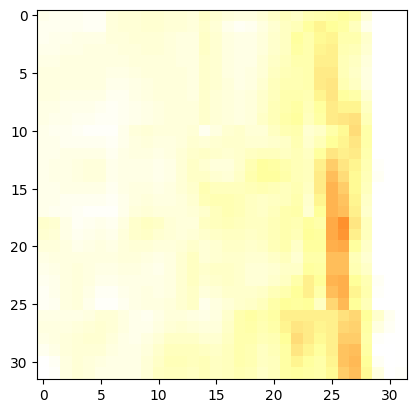

In [125]:
image,label=dataset[0]
print(image.shape,label)
plt.imshow(image.permute(1,2,0))

In [126]:
bs=20
train_dl=DataLoader(train_ds,batch_size=bs,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(train_ds,batch_size=bs,num_workers=4,pin_memory=True)

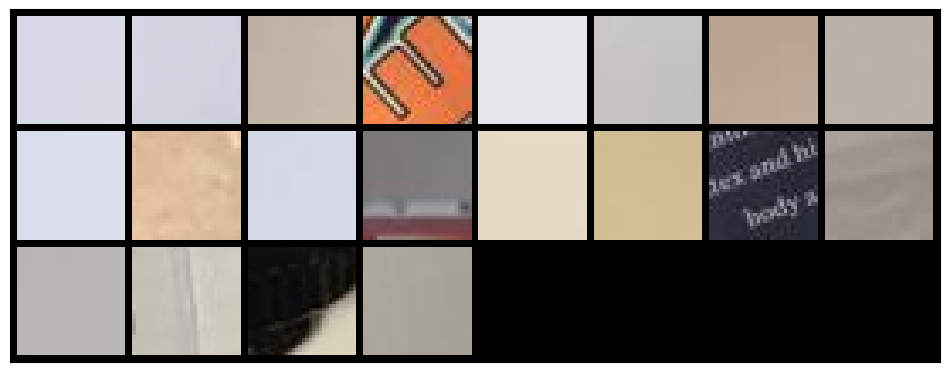

In [127]:
from torchvision.utils import make_grid

def denormalize(images,means,stds):
    means=torch.tensor(means).reshape(1,3,1,1)
    stds=torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorms_images=denormalize(images,*stats)
        ax.imshow(make_grid(denorms_images[:64],nrow=8).permute(1,2,0).clamp(0,1))
        break

show_batch(train_dl)

In [128]:
def to_device(data, device):
    if isinstance(data, (list, tuple)): # Fix: Use isinstance correctly
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [129]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [130]:
device=get_default_device()
device

device(type='cuda')

In [131]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


In [132]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x
    

In [133]:
simple_resnet=to_device(SimpleResidualBlock(),device)

In [134]:
for image,label in train_dl:
    out=simple_resnet(image)
    print(out.shape)
    break

del simple_resnet,image,label
torch.cuda.empty_cache()

torch.Size([20, 3, 32, 32])


In [154]:

def accuracy(out,label):
    _,pred=torch.max(out,dim=1)
    return torch.tensor(torch.sum(pred==label).item()/len(pred))


class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        image,label=batch
        out=self(image)
        loss=F.cross_entropy(out,label)
        return loss

    def validation_step(self,batch):
        image,label=batch
        out=self(image)
        val_loss=F.cross_entropy(out,label)
        val_acc=accuracy(out,label)
        return {'val_loss':val_loss,'val_acc':val_acc}

    def validation_epoch_end(self,output):
        batch_loss=[x['val_loss'] for x in output]
        epoch_loss=torch.stack(batch_loss).mean()
        batch_acc=[x['val_acc'] for x in output]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

    def epoch_end(self,epoch,result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
    @torch.no_grad
    def evaluate(self,val_loader):
        self.eval()
        output=[self.validation_step(batch) for batch in val_loader]
        return self.validation_epoch_end(output)

    

In [183]:
def conv_block(in_channel,out_channel,pool=False):
    layers=[nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1),
           nn.BatchNorm2d(out_channel),
           nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [184]:
# model=to_device(ResNet9(3,6),device)

# for image,label in train_dl:
#     print(image.shape)
#     out=model(image)
#     print(out.shape)
#     break

In [186]:
model=to_device(ResNet9(3,6),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [203]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,
                 weight_decay=0,grad_clip=None,
                 opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)

    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                             max_lr,epochs=epochs,
                                             steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()
        result=model.evaluate(val_loader)
        result['train_loss']=torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

            

In [204]:
history=[model.evaluate(val_dl)]

In [205]:
epochs=8
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [206]:
history +=fit_one_cycle(epochs,max_lr,model,train_dl,
                       val_dl,grad_clip=grad_clip,
                       weight_decay=weight_decay,
                       opt_func=opt_func)


Epoch [0], last_lr: 0.00393, train_loss: 1.9663, val_loss: 2.6713, val_acc: 0.2964
Epoch [1], last_lr: 0.00935, train_loss: 2.1949, val_loss: 3.2386, val_acc: 0.2691
Epoch [2], last_lr: 0.00972, train_loss: 2.5782, val_loss: 2.0705, val_acc: 0.3173
Epoch [3], last_lr: 0.00812, train_loss: 2.1007, val_loss: 2.1501, val_acc: 0.3142
Epoch [4], last_lr: 0.00556, train_loss: 1.9949, val_loss: 1.7931, val_acc: 0.3776
Epoch [5], last_lr: 0.00283, train_loss: 1.7438, val_loss: 1.7075, val_acc: 0.4209
Epoch [6], last_lr: 0.00077, train_loss: 1.6595, val_loss: 1.5088, val_acc: 0.4276
Epoch [7], last_lr: 0.00000, train_loss: 1.5888, val_loss: 1.5169, val_acc: 0.4214


In [207]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])

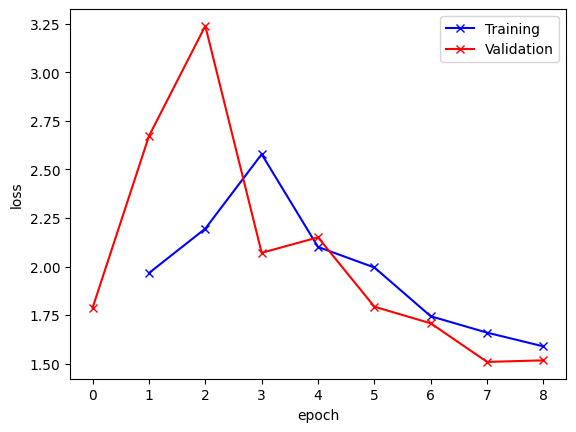

In [208]:
plot_losses(history)

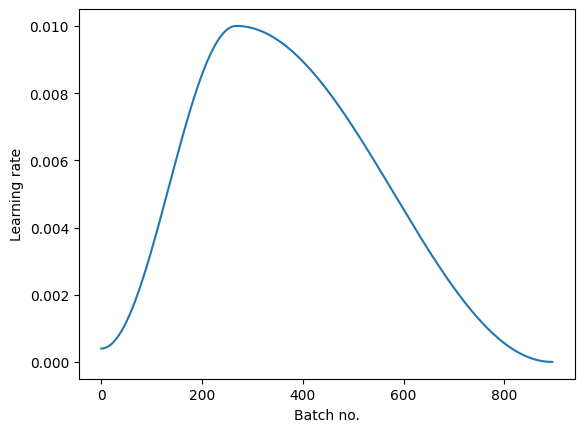

In [209]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')

plot_lrs(history)

In [237]:
def predict_image(img,model):
    xb=to_device(img.unsqueeze(0),device)
    yb=model(xb)
    _,pred=torch.max(yb,dim=1)
    return dataset.classes[pred[0].item()]

In [235]:
#for i,j in train_ds:
    #print(j)

Label: paper , Predicted: paper


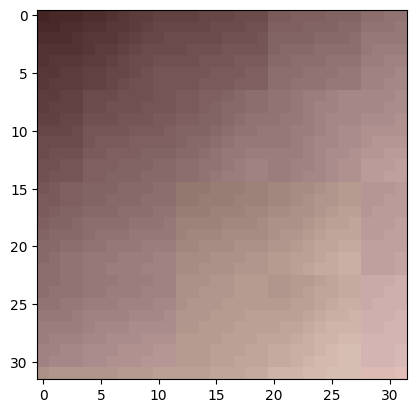

In [238]:
img, label = val_ds[10]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))